In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU Memory growth set successfully.")
    except RuntimeError as e:
        print("Error setting memory growth:", e)

GPU Memory growth set successfully.


In [2]:
import os
import json
import pandas as pd

In [3]:
base_dir = r'C:\Users\UTKARSH\Desktop\visual intelligence'
data_dir = r'C:\Users\UTKARSH\Desktop\visual intelligence\data'
models_dir = r'C:\Users\UTKARSH\Desktop\visual intelligence\image captioning 3\models'
pre_processed_data_dir = r'C:\Users\UTKARSH\Desktop\visual intelligence\image captioning 3\pre_processed_data'

In [4]:
train_captions = os.path.join(pre_processed_data_dir, 'train_captions.txt')
test_captions = os.path.join(pre_processed_data_dir, 'test_captions.txt')
train_img_dir = os.path.join(data_dir, 'train')
test_img_dir = os.path.join(data_dir, 'test')

In [5]:
TOTAL_IMAGES_TRAIN = len(os.listdir(train_img_dir))
TOTAL_IMAGES_TEST = len(os.listdir(test_img_dir))
TOTAL_CAPTIONS_TRAIN = TOTAL_IMAGES_TRAIN * 5
TOTAL_CAPTIONS_TEST = TOTAL_IMAGES_TEST * 5

In [6]:
!pip install contractions

In [7]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from PIL import Image
import string


class ImageFeatureExtractor:
    def __init__(self):
        self.model = self.create_inception_model()

    # Create the InceptionV3 model without the top layer
    def create_inception_model(self):
        base_model = InceptionV3(weights='imagenet', include_top=False)
        model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))
        return model

    # Preprocess image for InceptionV3 model
    def preprocess_image(self, image_path):
        img = Image.open(image_path).convert("RGB")  # Convert image to RGB to ensure 3 channels
        img = img.resize((299, 299))  # Resize to 299x299 (expected by InceptionV3)
        # img = np.array(img)
        img = np.array(img, dtype=np.float32) / 255.0
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        img = tf.keras.applications.inception_v3.preprocess_input(img)  # Preprocess for InceptionV3
        return img

    # Extract features for a given image
    def extract_features(self, image_path):
        try:
            img = self.preprocess_image(image_path)
            features = self.model.predict(img)
            return features.flatten()  # Flatten the features immediately
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
            return None

    # Extract features for the first `limit` images in the directory
    def extract_features_for_directory(self, image_dir, limit=100):
        image_features = {}
        img_files = os.listdir(image_dir)[:limit]

        for img_name in img_files:
            img_path = os.path.join(image_dir, img_name)

            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                print(f"Skipping unsupported file: {img_name}")
                continue

            img_id = os.path.splitext(img_name)[0]  # Remove file extension for unique ID

            features = self.extract_features(img_path)
            if features is not None:
                image_features[img_id] = features  # Store flattened features
        return image_features

In [9]:
import string
import re
import contractions
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
import nltk

# Download necessary NLTK resources
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [10]:
class CaptionProcessor:
    def __init__(self, captions_file, image_ids):
        self.captions_file = captions_file
        self.image_ids = image_ids  # Limit to selected image IDs

        self.stop_words = set(stopwords.words('english'))

        self.captions_dict = self.load_and_preprocess_captions()
        self.tokenizer = self.create_tokenizer()
        self.max_len = self.calculate_max_len()

    def load_and_preprocess_captions(self):
        with open(self.captions_file, 'r') as file:
            raw_captions = file.read()

        captions_dict = {}
        table = str.maketrans('', '', string.punctuation)

        for line in raw_captions.split('\n'):
            tokens = line.split(',')

            # Continue if the line is too short to contain a valid caption
            if len(tokens) < 2:
                continue

            image_id = tokens[0].split('.')[0]  # Extract image ID
            caption = ' '.join(tokens[1:]).strip()

            # Convert to lowercase
            caption = caption.lower()

            # Expand contractions (e.g., "can't" → "cannot")
            caption = contractions.fix(caption)

            # Remove punctuation
            caption = caption.translate(table)

            # Remove numbers
            caption = ''.join(char for char in caption if char.isalpha() or char.isspace())

            # Normalize whitespace
            caption = re.sub(r'\s+', ' ', caption).strip()

            # Remove stopwords (optional)
            caption = ' '.join([word for word in caption.split() if word not in self.stop_words])

            # Remove Single character word.
            caption = ' '.join([word for word in caption.split() if len(word) > 1])

            if not caption:  # Skip empty captions
                continue

            # Capitalize the first letter of the caption
            caption = caption[0].upper() + caption[1:]

            if image_id in self.image_ids:  # Only use captions for selected images
                if image_id not in captions_dict:
                    captions_dict[image_id] = []
                captions_dict[image_id].append('startseq ' + caption + ' endseq')
        return captions_dict

    def create_tokenizer(self):
        all_captions = []
        for key in self.captions_dict:
            all_captions.extend(self.captions_dict[key])
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(all_captions)
        return tokenizer

    def calculate_max_len(self):
        return max(len(caption.split()) for captions in self.captions_dict.values() for caption in captions)

    def create_sequences(self, image_features, vocab_size):
        X1, X2, y = [], [], []

        for key, captions_list in self.captions_dict.items():
            if key not in image_features:  # Skip keys not in image_features
                continue

            for caption in captions_list:
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_len)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(image_features[key])  # Use flattened image features
                    X2.append(in_seq)
                    y.append(out_seq)

        return np.array(X1), np.array(X2), np.array(y)

def generate_caption(model, image_feature, tokenizer, max_len):
        in_text = 'startseq'

        for _ in range(max_len):
            sequence = tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], maxlen=max_len)

            # Predict next word
            yhat = model.predict([image_feature, sequence], verbose=0)
            yhat = np.argmax(yhat)

            # Convert index to word
            word = tokenizer.index_word.get(yhat, None)

            if not word:  # If word is None, skip to next iteration
              continue

            in_text += ' ' + word
            if word == 'endseq':
                break

        return in_text


In [11]:
from tensorflow.keras.utils import Sequence
class ImageCaptionDataGenerator(Sequence):
    def __init__(self, image_features, captions_dict, tokenizer, max_len, vocab_size, batch_size=32):
        self.image_features = image_features
        self.captions_dict = captions_dict
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.image_ids = list(image_features.keys())

    def __len__(self):
        return int(np.ceil(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        batch_image_ids = self.image_ids[index * self.batch_size: (index + 1) * self.batch_size]
        X1, X2, y = [], [], []
        for image_id in batch_image_ids:
            image_feature = self.image_features[image_id]
            for caption in self.captions_dict.get(image_id, []):
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_len)[0]
                    out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(image_feature)
                    X2.append(in_seq)
                    y.append(out_seq)
        return [np.array(X1, dtype=np.float32), np.array(X2, dtype=np.float32)], np.array(y, dtype=np.float32)

In [12]:
import os
import json
import pickle
import string
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Add, Input, Masking, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger

In [13]:
# Step 1: Extract image features
extractor = ImageFeatureExtractor()

# train_image_features = extractor.extract_features_for_directory(train_img_dir, limit=30000)
# pickle.dump(train_image_features, open(os.path.join(pre_processed_data_dir, 'train_image_features.pkl'), 'wb'))


# test_image_features = extractor.extract_features_for_directory(test_img_dir, limit=3000)
# pickle.dump(test_image_features, open(os.path.join(pre_processed_data_dir, 'test_image_features.pkl'), 'wb'))


In [14]:
train_image_features = pickle.load(open(os.path.join(pre_processed_data_dir, 'train_image_features.pkl'), 'rb'))
test_image_features = pickle.load(open(os.path.join(pre_processed_data_dir, 'test_image_features.pkl'), 'rb'))

In [15]:
#Custom Model
def build_model(vocab_size, max_len):
    image_input = Input(shape=(2048,))  # 2048 features from InceptionV3
    image_dense = Dense(256, activation='relu')(image_input)
    # Image feature input

    # Sequence input
    seq_input = Input(shape=(max_len,))
    seq_masking = Masking(mask_value=0)(seq_input)
    seq_embedding = Embedding(vocab_size, 256, mask_zero=False)(seq_masking)

    # Stacking three LSTM layers
    lstm_1 = LSTM(256, return_sequences=True, name="lstm_layer_1")(seq_embedding)
    lstm_2 = LSTM(256, return_sequences=True, name="lstm_layer_2")(lstm_1)
    lstm_3 = LSTM(256, name="lstm_layer_3")(lstm_2)

    # Combine the inputs
    combined = Add()([image_dense, lstm_3])
    output = Dense(vocab_size, activation='softmax')(combined)

    model = Model(inputs=[image_input, seq_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    return model

In [16]:
# Step 2: Process captions for the selected images
train_image_ids = list(train_image_features.keys())
train_processor = CaptionProcessor(train_captions, train_image_ids)

test_image_ids = list(test_image_features.keys())
test_processor = CaptionProcessor(test_captions, test_image_ids)

VOCAB_SIZE = len(train_processor.tokenizer.word_index) + 1
MAX_LEN = train_processor.max_len

In [17]:
train_generator = ImageCaptionDataGenerator(train_image_features, train_processor.captions_dict, train_processor.tokenizer, MAX_LEN, VOCAB_SIZE, batch_size=32)
test_generator = ImageCaptionDataGenerator(test_image_features, test_processor.captions_dict, test_processor.tokenizer, MAX_LEN, VOCAB_SIZE, batch_size=32)

In [18]:
mymodel = build_model(VOCAB_SIZE, MAX_LEN)
mymodel.summary()
# plot_model(mymodel, show_shapes=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 31)]         0           []                               
                                                                                                  
 masking (Masking)              (None, 31)           0           ['input_3[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 31, 256)      3983104     ['masking[0][0]']                
                                                                                                  
 lstm_layer_1 (LSTM)            (None, 31, 256)      525312      ['embedding[0][0]']              
                                                                                            

In [19]:
history = mymodel.fit(train_generator, epochs=50, validation_data=test_generator)

Epoch 1/50
938/938 [==============================] - 116s 116ms/step - loss: 5.9114 - val_loss: 6.6026
Epoch 2/50
938/938 [==============================] - 108s 115ms/step - loss: 5.0516 - val_loss: 6.9781
Epoch 3/50
938/938 [==============================] - 108s 115ms/step - loss: 4.6907 - val_loss: 7.1318
Epoch 4/50
938/938 [==============================] - 107s 114ms/step - loss: 4.4703 - val_loss: 7.2739
Epoch 5/50
938/938 [==============================] - 107s 114ms/step - loss: 4.3161 - val_loss: 7.3809
Epoch 6/50
938/938 [==============================] - 108s 116ms/step - loss: 4.1981 - val_loss: 7.4808
Epoch 7/50
938/938 [==============================] - 108s 115ms/step - loss: 4.1013 - val_loss: 7.5696
Epoch 8/50
938/938 [==============================] - 108s 115ms/step - loss: 4.0165 - val_loss: 7.6585
Epoch 9/50
938/938 [==============================] - 107s 114ms/step - loss: 3.9426 - val_loss: 7.7642
Epoch 10/50
938/938 [==============================] - 106s 113m

In [20]:
def plot_history(history):

    loss = history.history['loss']
    # val_loss = history.history['val_loss']

    epochs_range = range(len(loss))

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    # plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

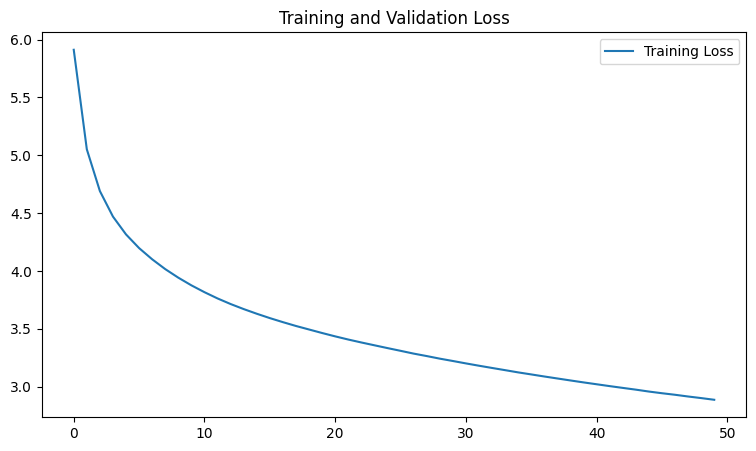

In [21]:
plot_history(history)

In [22]:
mymodel.save(os.path.join(models_dir,'custom_model.h5'))

In [23]:
load_model = load_model(os.path.join(models_dir,'custom_model.h5'))

1/1 [==============================] - 0s 39ms/step
Actual Caption: ----------------------------
startseq Two cups sitting top gray counter endseq
startseq Cup bird cup wolf endseq
startseq Two ceramic cups one bird fox endseq
startseq Two cups painted animal pictures endseq
startseq Two cup like things bird wolf painted endseq
--------------------------------------------
Generated Caption:  startseq two stopped computer looking endseq


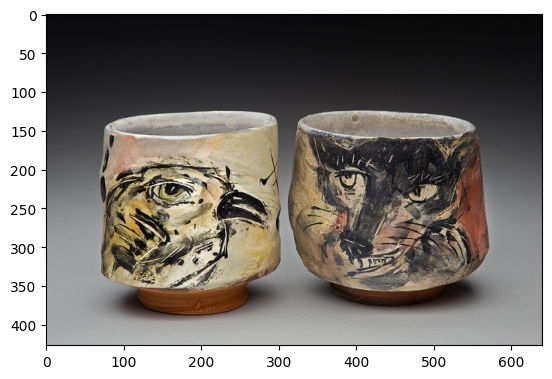

In [57]:
# Step 5: Test caption generation on a new image

model = load_model
random_id = np.random.choice(list(test_processor.captions_dict.keys()))
cap_id = random_id
test_image_path = os.path.join(test_img_dir, cap_id +'.jpg')
test_image_feature = extractor.extract_features(test_image_path)
test_image_feature = np.squeeze(test_image_feature)
generated_caption = generate_caption(model, np.array([test_image_feature]), test_processor.tokenizer, MAX_LEN)

print("Actual Caption: ----------------------------")
for cap in test_processor.captions_dict[cap_id]:
  print(cap)
print("--------------------------------------------")

print("Generated Caption: ", generated_caption)

# Display the image
img = Image.open(test_image_path)
plt.imshow(img)
plt.show()

1/1 [==============================] - 0s 48ms/step
000000040056
Actual Caption: ----------------------------
startseq Parking meter city street arabic writing endseq
startseq Blue yellow metal box key slot metal pole sidewalk endseq
startseq Blue yellow lock box standing next street endseq
startseq Locked box top post street endseq
startseq Colorful parking meter next curb highway endseq
--------------------------------------------
Generated Caption:  startseq man standing next woman holding wine glass endseq


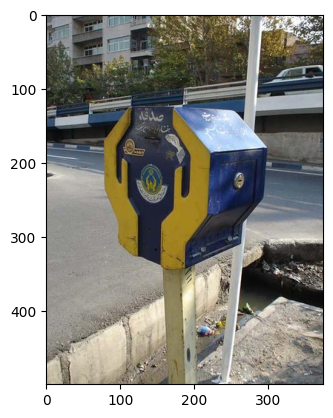

In [59]:
# Step 5: Train caption generation on a new image

model = load_model
random_id = np.random.choice(list(train_processor.captions_dict.keys()))
cap_id = random_id
train_image_path = os.path.join(train_img_dir, cap_id +'.jpg')
train_image_feature = extractor.extract_features(train_image_path)
train_image_feature = np.squeeze(train_image_feature)
generated_caption = generate_caption(model, np.array([train_image_feature]), train_processor.tokenizer, MAX_LEN)
print(random_id)
print("Actual Caption: ----------------------------")
for cap in train_processor.captions_dict[cap_id]:
  print(cap)
print("--------------------------------------------")

print("Generated Caption: ", generated_caption)

# Display the image
img = Image.open(train_image_path)
plt.imshow(img)
plt.show()

In [33]:
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calculate_bleu(test_features, test_captions, model, tokenizer, MAX_LEN):
    bleu_1_scores, bleu_2_scores, bleu_3_scores, bleu_4_scores = [], [], [], []

    for image_id, image_features in tqdm(test_features.items(), desc="Calculating BLEU Scores", unit="image"):
        predicted_caption = generate_caption(model, np.array([image_features]), tokenizer, MAX_LEN)
        predicted_caption = predicted_caption.split()

        # Get the list of ground truth captions for this image
        reference_captions = [caption.split() for caption in test_captions.get(image_id, [])]

        # Smoothing function for higher n-grams
        smooth_fn = SmoothingFunction().method1

        # Compute BLEU scores
        bleu_1 = sentence_bleu(reference_captions, predicted_caption, weights=(1, 0, 0, 0), smoothing_function=smooth_fn)
        bleu_2 = sentence_bleu(reference_captions, predicted_caption, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth_fn)
        bleu_3 = sentence_bleu(reference_captions, predicted_caption, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth_fn)
        bleu_4 = sentence_bleu(reference_captions, predicted_caption, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth_fn)

        # Store BLEU scores
        bleu_1_scores.append(bleu_1)
        bleu_2_scores.append(bleu_2)
        bleu_3_scores.append(bleu_3)
        bleu_4_scores.append(bleu_4)

    # Return average BLEU scores
    return [np.mean(bleu_1_scores), np.mean(bleu_2_scores), np.mean(bleu_3_scores), np.mean(bleu_4_scores)]


In [34]:
bleu_score = calculate_bleu(test_image_features, test_processor.captions_dict, model, test_processor.tokenizer, MAX_LEN)
print(f"Average BLEU-1 Score on Test Dataset: {bleu_score[0]:.4f}")
print(f"Average BLEU-2 Score on Test Dataset: {bleu_score[1]:.4f}")
print(f"Average BLEU-3 Score on Test Dataset: {bleu_score[2]:.4f}")
print(f"Average BLEU-4 Score on Test Dataset: {bleu_score[3]:.4f}")

Calculating BLEU Scores: 100%|██████████████████████████████████████████████████| 3000/3000 [26:11<00:00,  1.91image/s]

Average BLEU-1 Score on Test Dataset: 0.3363
Average BLEU-2 Score on Test Dataset: 0.0780
Average BLEU-3 Score on Test Dataset: 0.0498
Average BLEU-4 Score on Test Dataset: 0.0405


In [ ]:
bleu_score = calculate_bleu(train_image_features, train_processor.captions_dict, model, train_processor.tokenizer, MAX_LEN)
print(f"Average BLEU-1 Score on Test Dataset: {bleu_score[0]:.4f}")
print(f"Average BLEU-2 Score on Test Dataset: {bleu_score[1]:.4f}")
print(f"Average BLEU-3 Score on Test Dataset: {bleu_score[2]:.4f}")
print(f"Average BLEU-4 Score on Test Dataset: {bleu_score[3]:.4f}")

Calculating BLEU Scores:   2%|█                                               | 221/10000 [01:49<1:21:42,  1.99image/s]